In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime
import math
import tensorflow.keras as keras

## Chargement des données
On utilisera ici l'excellent OpenData public.opendatasoft.com, qui nous met gentiement à disposition des données météorologiques pour la région parisienne.

In [3]:
data_url = "https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/download/?format=csv&refine.nom_epci=M%C3%A9tropole+du+Grand+Paris&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"

In [4]:
data = pd.read_csv(data_url, sep=";")
data = data.sort_values("Date")

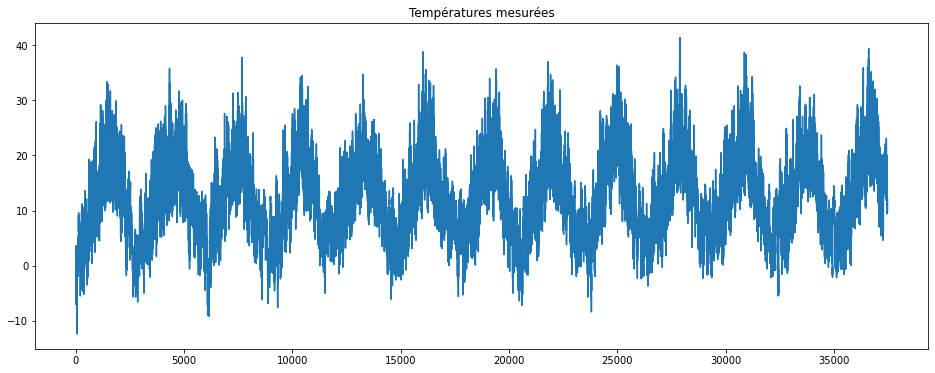

In [6]:
plt.figure(figsize=(16,6))
plt.title("Températures mesurées")

number = len(data)
plt.plot(data["Température (°C)"][0:number].values)

Modèle Auto-prédictif

In [57]:
x, y = [], []
window_size = 50

use_prev = True

def norm_temp(tmp):
    return (tmp - 12) / 7

for i in range(3, len(data)):
    
    date = datetime.datetime.strptime(data["Date"][i].split("+")[0], '%Y-%m-%dT%H:%M:%S')
    date_vect = np.zeros(86 if use_prev else 37)
    date_vect[date.month] = 1.0
    date_vect[date.hour + 12] = 1.0
    date_vect[36] = date.year-2000

    tmp = norm_temp(float(data["Température (°C)"][i]))

    if use_prev:
        prev_date = datetime.datetime.strptime(data["Date"][i-1].split("+")[0], '%Y-%m-%dT%H:%M:%S')
        date_vect[37] = norm_temp(data["Température (°C)"][i-1])
        date_vect[38+prev_date.hour] = 1.0
        prev_date = datetime.datetime.strptime(data["Date"][i-2].split("+")[0], '%Y-%m-%dT%H:%M:%S')
        date_vect[62] = norm_temp(data["Température (°C)"][i-2])
        date_vect[62+prev_date.hour] = 1.0
        
        if not math.isnan(tmp) and not math.isnan(date_vect[37]) and not math.isnan(date_vect[62]):
            x.append(date_vect)
            y.append([tmp])
    
    else:
        if not math.isnan(tmp):
            x.append(date_vect)
            y.append([tmp])

x = np.array(x)
y = np.array(y)
print(len(x))
print(np.mean(y), np.std(y))

37465
0.05495033459800903 1.042051536076358


In [58]:
split = int(len(x) * 0.8)
x_train, x_test = x[0:split], x[split:len(x)]
y_train, y_test = y[0:split], y[split:len(x)]

In [65]:
from sklearn.linear_model import LinearRegression

modl = LinearRegression().fit(x_train, y_train)

print("r2 -> train", modl.score(x_train, y_train))
print("r2 -> test", modl.score(x_test, y_test))

r2 -> train 0.7445995540886811
r2 -> test 0.7574196211413772


In [68]:
mse = np.mean(np.abs((y+12)*7 - (modl.predict(x)+12)*7))
print("mean_error", mse)

mean_error 2.9057619422659062


In [89]:
model = keras.Sequential()
model.add(keras.layers.Dense(15, activation="relu", input_shape=(len(x[0]),)))
model.add(keras.layers.Dense(5, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 15)                1305      
                                                                 
 dense_19 (Dense)            (None, 5)                 80        
                                                                 
 dense_20 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,391
Trainable params: 1,391
Non-trainable params: 0
_________________________________________________________________


In [90]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
235/235 [==============================] - 1s 2ms/step - loss: 1.1278 - val_loss: 1.2453
Epoch 2/40
235/235 [==============================] - 0s 2ms/step - loss: 0.9329 - val_loss: 1.1220
Epoch 3/40
235/235 [==============================] - 0s 2ms/step - loss: 0.8078 - val_loss: 0.9297
Epoch 4/40
235/235 [==============================] - 0s 1ms/step - loss: 0.6508 - val_loss: 0.7024
Epoch 5/40
235/235 [==============================] - 0s 1ms/step - loss: 0.5242 - val_loss: 0.5608
Epoch 6/40
235/235 [==============================] - 0s 1ms/step - loss: 0.4394 - val_loss: 0.4549
Epoch 7/40
235/235 [==============================] - 0s 1ms/step - loss: 0.3814 - val_loss: 0.3921
Epoch 8/40
235/235 [==============================] - 0s 1ms/step - loss: 0.3420 - val_loss: 0.3539
Epoch 9/40
235/235 [==============================] - 0s 1ms/step - loss: 0.3162 - val_loss: 0.3215
Epoch 10/40
235/235 [==============================] - 0s 1ms/step - loss: 0.2997 - val_loss: 0.3034

mean_error 2.9084788055195916


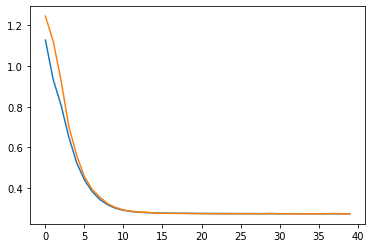

In [91]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

mse = np.mean(np.abs((y+12)*7 - (model.predict(x)+12)*7))
print("mean_error", mse)